In [1]:
import importlib
import pandas as pd
import xarray as xr
import numpy as np
import datetime as dt
from numpy import nan
from constants import *
import sys
import warnings
import math
import os
import cftime
from glob import glob
from timeit import default_timer as timer # try to measure time
from CASutils import readdata_utils as read
from CASutils import calendar_utils as cal

In [2]:
# define functions
def read_cmip6(filepath,datestart,dateend):
    #open netcdf dataset
    dat = xr.open_mfdataset(filepath, coords="minimal", join="override", decode_times = True, use_cftime=True)  
    #convert calendar to standard, setting missing values as NaNs
    dat = dat.convert_calendar("standard", use_cftime=True, align_on="date",missing=np.nan)
    #interpolate the dataset using cftim_range
    dateidx = xr.cftime_range(datestart,dateend,freq='D',calendar="standard") 
    dat = dat.interp(time=dateidx,method="nearest") 
    #take slice
    dat = dat.sel(time=slice(datestart, dateend))
    dat = xr.decode_cf(dat, use_cftime = True) 
    return dat

#def read_field(filepath, datestart, dateend,latmin,latmax,plev):
#    """Read in a time slice from datestart to dateend and calculate the zonal mean.
#    Try using datetime64 and if that doesn't work decode times manually.
#    Args:
#        filepath (string) = path to files e.g., "/path/to/files/*.nc"
#        datestart (string) = start date for time slice
#        dateend (string) = end date for time slice
#    """
#
#    try:
#        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
#                 decode_times=True, use_cftime=True).\
#                 sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
#
#    except:
#                
#        print("Something's wierd about the time axis, decoding manually")
#        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
#                   decode_times=False)
#
#        dat=xr.decode_cf(dat, use_cftime=True)
#        dat=dat.sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
#        datetimeindex=dat.indexes['time'].to_datetimeindex()
#        dat['time'] = datetimeindex
#
#    return dat

def read_field(filepath, datestart, dateend,latmin,latmax,plev):
    """Read in a time slice from datestart to dateend and calculate the zonal mean.
    Try using datetime64 and if that doesn't work decode times manually.
    Args:
        filepath (string) = path to files e.g., "/path/to/files/*.nc"
        datestart (string) = start date for time slice
        dateend (string) = end date for time slice
    """

    try:
        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
                 decode_times=True, use_cftime=True)

    except:
                
        print("Something's wierd about the time axis, decoding manually")
        dat = xr.open_mfdataset(filepath, coords="minimal", join="override",
                   decode_times=False)

        dat=xr.decode_cf(dat, use_cftime=True)
        datetimeindex=dat.indexes['time'].to_datetimeindex()
        dat['time'] = datetimeindex
        
    dat=dat.sel(time=slice(datestart, dateend),lat=slice(latmin,latmax),plev=plev)
    return dat

def get_lat_lon_res(ds):
    '''Function to obtain the average lat and lon gridspacing from a dataset of a non regular model grid. '''
    lat = ds.coords['lat']
    lon = ds.coords['lon']
    difflat = lat - lat.shift(lat=1)
    latres = difflat.mean().to_numpy()
    difflon = lon - lon.shift(lon=1)
    lonres = difflon.mean().to_numpy()
    return latres, lonres

def def_domain(ncdf,min_lat,max_lat,min_lon,max_lon):
    LatIndexer, LonIndexer = 'lat', 'lon'
    ncdf = ncdf.loc[{LatIndexer: slice(min_lat, max_lat),
                      LonIndexer: slice(min_lon, max_lon)}]
    return ncdf

def norm_lon(ncdf):
    ncdf.coords['lon'] = (ncdf.coords['lon'] + 180) % 360 - 180
    return ncdf.sortby(ncdf.lon)

def get_ONDJFM_day(ncdf, months=[1,2,3,10,11,12],timedim="day"):
    return ncdf.isel({timedim:ncdf[timedim].dt.month.isin(months)})

In [3]:
os.chdir('/home/lseverino/MT/scripts')
importlib.reload(read)
importlib.reload(cal)
warnings.filterwarnings('ignore')


In [4]:
## constants
#paths
histpath="/net/atmos/data/cmip6/historical/"
ssp119path="/net/atmos/data/cmip6/ssp119/"
ssp126path="/net/atmos/data/cmip6/ssp126/"
ssp245path="/net/atmos/data/cmip6/ssp245/"
ssp370path="/net/atmos/data/cmip6/ssp370/"
ssp585path="/net/atmos/data/cmip6/ssp585/"

scenlist = ["historical","ssp126","ssp245","ssp370","ssp585"]
pathlist = [histpath,ssp126path,ssp245path,ssp370path,ssp585path]
pathdic = {"historical":histpath,"ssp126":ssp126path,"ssp245":ssp245path,"ssp370":ssp370path,"ssp585":ssp585path}
tres = "day/"
var="sfcWindmax"
pathout="../cmip6/"+var+'/'

cmip6models=pd.read_csv('../cmip6csvinfo/cmip6csvinfo_timeseries_ssp585_luca_daily.csv')




In [20]:
### constants
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
#dict for abbreviations of the cmip6 variables names
cmip6vars = {'sfcWindmax':'SWM','sfcWind':'SW','psl':'SLP','ua':'UA',}
##preprocessing and objects constants
gst_fact = 1.67
qt = 0.98
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
processings = ["qt98","gst1-67","cutarea0","cal1"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)
lst_bn_proc = processings+metvar+spaceres+timeres+domain+season
basenamemet_proc = sep.join(lst_bn_proc)





In [6]:
# get directories and member names
nmems_hist = dict()
#nmems_ssp119 = dict()
nmems_ssp126 = dict()
nmems_ssp245 = dict()
nmems_ssp370 = dict()
nmems_ssp585 = dict()
models_df = pd.DataFrame(columns=scenlist)
for ind,path in enumerate(pathlist):
    for subdir in os.scandir(path+tres+var):
        models_df.loc[subdir.name,scenlist[ind]] = len(os.listdir(subdir))
    
models_df.loc["total",:] = models_df.count(axis=0)

In [46]:
models_df[['historical','ssp585']].dropna()

,historical,ssp585
AWI-CM-1-1-MR,5,1
BCC-CSM2-MR,1,1
CanESM5,50,50
CNRM-CM6-1,30,6
CNRM-ESM2-1,10,5
CNRM-CM6-1-HR,1,1
EC-Earth3-Veg,9,8
EC-Earth3,23,3
EC-Earth3-Veg-LR,3,3
EC-Earth3-CC,3,1


In [8]:
models_df

,historical,ssp126,ssp245,ssp370,ssp585
AWI-CM-1-1-MR,5,1,1,5,1
AWI-ESM-1-1-LR,1,NaN,NaN,NaN,NaN
BCC-CSM2-MR,1,1,1,1,1
BCC-ESM1,1,NaN,NaN,3,NaN
CanESM5,50,50,50,50,50
CNRM-CM6-1,30,6,6,6,6
CNRM-ESM2-1,10,5,10,3,5
CNRM-CM6-1-HR,1,1,1,1,1
EC-Earth3-Veg,9,7,8,6,8
EC-Earth3,23,3,43,3,3


In [7]:
#select all models with minimum 3 members for the 5 scenarios
mods_3mem_allscen = models_df.where(models_df>=3).dropna(how='any').iloc[:-1,:]
mods_1mem_allscen = models_df.where(models_df>=1).dropna(how='any').iloc[:-1,:]
mods_1mem_hist_ssp585= models_df[["historical","ssp585"]].where(models_df[["historical","ssp585"]]>=1).dropna(how='any').iloc[:-1,:]


In [48]:
mods_1mem_hist_ssp585

,historical,ssp585
AWI-CM-1-1-MR,5,1
BCC-CSM2-MR,1,1
CanESM5,50,50
CNRM-CM6-1,30,6
CNRM-ESM2-1,10,5
CNRM-CM6-1-HR,1,1
EC-Earth3-Veg,9,8
EC-Earth3,23,3
EC-Earth3-Veg-LR,3,3
EC-Earth3-CC,3,1


In [20]:
modlist_allscen+modlist_ssp585

['CanESM5',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'FGOALS-g3',
 'ACCESS-ESM1-5',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'KACE-1-0-G',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CNRM-CM6-1-HR',
 'EC-Earth3-CC',
 'HadGEM3-GC31-LL',
 'GISS-E2-1-G',
 'GFDL-CM4',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'HadGEM3-GC31-MM',
 'NESM3',
 'MPI-ESM1-2-HR',
 'INM-CM4-8',
 'INM-CM5-0',
 'ACCESS-CM2']

In [8]:
#create table with model considered for the thesis
mods_1mem_allscen[(mods_1mem_allscen>3)] =3
modlist_not_allscen = mods_1mem_allscen[(mods_1mem_allscen['ssp126'] < 3 ) | (mods_1mem_allscen['ssp245'] < 3 ) | (mods_1mem_allscen['ssp370'] < 3 )].index.tolist()
mods_1mem_allscen.loc[modlist_not_allscen,['ssp126','ssp245','ssp370']] = np.nan


In [54]:
mods_1mem_allscen

,historical,ssp126,ssp245,ssp370,ssp585
AWI-CM-1-1-MR,3,NaN,NaN,NaN,1
BCC-CSM2-MR,1,NaN,NaN,NaN,1
CanESM5,3,3,3,3,3
CNRM-CM6-1,3,3,3,3,3
CNRM-ESM2-1,3,3,3,3,3
CNRM-CM6-1-HR,1,NaN,NaN,NaN,1
EC-Earth3-Veg,3,3,3,3,3
EC-Earth3,3,3,3,3,3
EC-Earth3-Veg-LR,3,3,3,3,3
IPSL-CM6A-LR,3,3,3,3,3


In [8]:
models_diff = pd.DataFrame()
for scen in scenlist[1:]:
    colname =  scen+" - hist"
    models_diff.loc[:,colname] = abs(models_df.loc[::-1,scen]-models_df.loc[::-1,"historical"])

In [9]:
# get populate dict with model names and member names
# force to get the same members as for sfcWindmax
varSWM = 'sfcWindmax'
tresSWM = 'day/'
dicscen = dict()
for ind,scen in enumerate(scenlist):
    path = pathlist[ind]
    dicscen[scen] = dict()
    for subdir in os.scandir(path+tresSWM+varSWM):
        #models_rcp85[subdir.name]=[]
        dicscen[scen][subdir.name] = [len(os.listdir(subdir))]
        dicscen[scen][subdir.name].append(os.listdir(subdir))
nmems_hist = dicscen['historical']
nmems_ssp585 = dicscen['ssp585']

In [10]:
# turn dicts into pd DataFrames because more convenient
nmems_hist_df = pd.DataFrame(nmems_hist, index=["hist","memnames"])
nmems_ssp585_df = pd.DataFrame(nmems_ssp585, index=["ssp585","memnames"])

In [11]:
# get common models that are both in historical and rcp85
nmems_hist_com = nmems_hist_df.reindex(nmems_ssp585_df.columns,axis=1).dropna(axis=1)
nmems_ssp585_com = nmems_ssp585_df.reindex(nmems_hist_df.columns,axis=1).dropna(axis=1)

In [12]:
#consider ONJDFM: start in D, finishes in M, adjust to have same number of days in both periods
ybegp = 1980 ; monbegp = 10 ; yendp = 2010 ; monendp = 3 ; daybegp = 1 ; dayendp = 30# dates for Past period, only takes 30th 
#ybegf = 2070 ; monbegf = 1 ; yendf = 2099 ; monendf = 12 ; daybegf = 1 ; dayendf = 31# dates for Future period
ybegf = 2070 ; monbegf = 10 ; yendf = 2100 ; monendf = 3 ; daybegf = 1 ; dayendf = 30# otherwise dont have the same length

# total number of months (used for checking)
nmonthsp = (yendp-ybegp-1)*12 + (12-monbegp+1) + monendp
nmonthsf = (yendf-ybegf-1)*12 + (12-monbegf+1) + monendf

# set up date names
dateformat ='%Y-%m-%d'

datebegp=str(ybegp)+"-"+str(monbegp).zfill(2)+"-"+str(daybegp).zfill(2)
dateendp=str(yendp)+"-"+str(monendp).zfill(2)+"-"+str(dayendp).zfill(2)
datebegf=str(ybegf)+"-"+str(monbegf).zfill(2)+"-"+str(daybegf).zfill(2)
dateendf=str(yendf)+"-"+str(monendf).zfill(2)+"-"+str(dayendf).zfill(2)

#set up daterange indexes
#daysidp = pd.date_range(datebegp,dateendp,freq='D')
#daysidf = pd.date_range(datebegf,dateendf,freq='D')

daysidp = xr.cftime_range(datebegp,dateendp,freq='D',calendar='standard')
daysidf = xr.cftime_range(datebegf,dateendf,freq='D',calendar='standard')

#nb of days
ndaysp = len(daysidp)
ndaysf = len(daysidf)

dayrangep = np.arange(1,ndaysp+1,1)
dayrangef = np.arange(1,ndaysf+1,1)

latout=np.linspace(-90,90,73)
lonout=np.linspace(0,357.5,144)
#lonout=np.linspace(0,360,144) # try to remove issues at border

# plevuse=[100000,92500,85000,70000,60000,50000,40000,30000,25000,20000,15000,10000,
#        7000,5000,3000,2000,1000]
# plevuse=[1000]



In [13]:
## select models
#try with models that have at least 3 members per scenario
modlist_3mem = mods_3mem_allscen.index.tolist()
modlist_1mem_sel = mods_1mem_hist_ssp585.drop(index=mods_3mem_allscen.index)
#modlist_1mem_sel = modlist_1mem_sel.drop(index=['HadGEM3-GC31-MM','HadGEM3-GC31-LL'])
model_dl = ['AWI-CM-1-1-MR']
modlist = ['MPI-ESM1-2-HR']
modlist = [model for model in modlist if model not in model_dl]

for model in modlist:
    print("Members, historical: "+str(nmems_hist[model][0])+"\nMembers, rcp85: ",str(dicscen['ssp585'][model][0]))
models = pd.Series(modlist)

Members, historical: 10
Members, rcp85:  2


In [22]:
##select scenarios
selscen = ['historical','ssp585']
var ="sfcWindmax"
tres = "day/"
regrid=False

#get member names
memname_df = pd.read_csv('/home/lseverino/MT/metadata/memnames_ssp585_hist_SWM.csv',header=[0,1],index_col=0)

In [18]:
memname_df

scen               historical                           ssp585             \
imem                        0          1          2          0          1   
CanESM5             r10i1p1f1  r10i1p2f1  r11i1p1f1  r10i1p1f1  r10i1p2f1   
CNRM-CM6-1          r10i1p1f2   r1i1p1f2   r2i1p1f2   r1i1p1f2   r2i1p1f2   
CNRM-ESM2-1          r1i1p1f2   r2i1p1f2   r3i1p1f2   r1i1p1f2   r4i1p1f2   
EC-Earth3-Veg        r1i1p1f1   r4i1p1f1   r2i1p1f1   r2i1p1f1   r3i1p1f1   
EC-Earth3-Veg-LR     r1i1p1f1   r2i1p1f1   r3i1p1f1   r1i1p1f1   r2i1p1f1   
IPSL-CM6A-LR        r10i1p1f1  r11i1p1f1  r12i1p1f1  r14i1p1f1   r4i1p1f1   
MIROC-ES2L        r1i1000p1f2  r13i1p1f2  r11i1p1f2   r1i1p1f2  r10i1p1f2   
UKESM1-0-LL          r1i1p1f2   r2i1p1f2   r3i1p1f2   r1i1p1f2   r4i1p1f2   
MRI-ESM2-0           r1i1p1f1   r2i1p1f1   r3i1p1f1   r1i1p1f1   r1i2p1f1   
FGOALS-g3            r1i1p1f1   r3i1p1f1   r5i1p1f1   r1i1p1f1   r3i1p1f1   
ACCESS-ESM1-5        r1i1p1f1   r3i1p1f1   r2i1p1f1   r1i1p1f1   r3i1p1f1   
MIROC6              r10i1p1f1   r1i1p1f1   r2i1p1f1   r1i1p1f1   r2i1p1f1   
MPI-ESM1-2-LR       r10i1p1f1   r9i1p1f1   r5i1p1f1   r1i1p1f1  r10i1p1f1   
KACE-1-0-G           r2i1p1f1   r1i1p1f1   r3i1p1f1   r1i1p1f1   r2i1p1f1   
AWI-CM-1-1-MR        r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
BCC-CSM2-MR          r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CNRM-CM6-1-HR        r1i1p1f2        NaN        NaN   r1i1p1f2        NaN   
EC-Earth3-CC         r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
HadGEM3-GC31-LL      r1i1p1f3   r2i1p1f3   r3i1p1f3   r1i1p1f3   r3i1p1f3   
GISS-E2-1-G          r1i1p1f1        NaN        NaN   r1i1p1f2        NaN   
GFDL-CM4             r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CMCC-CM2-SR5         r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
CMCC-ESM2            r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
HadGEM3-GC31-MM      r1i1p1f3   r2i1p1f3   r4i1p1f3   r1i1p1f3   r3i1p1f3   
NESM3                r1i1p1f1   r2i1p1f1        NaN   r2i1p1f1   r1i1p1f1   
MPI-ESM1-2-HR       r10i1p1f1   r4i1p1f1        NaN   r1i1p1f1   r2i1p1f1   
INM-CM4-8            r1i1p1f1        NaN        NaN   r1i1p1f1        NaN   
INM-CM5-0            r5i1p1f1        NaN        NaN   r1i1p1f1        NaN   
ACCESS-CM2           r4i1p1f1   r5i1p1f1        NaN   r4i1p1f1   r5i1p1f1   

scen                        
imem                     2  
CanESM5           r1i1p1f1  
CNRM-CM6-1        r3i1p1f2  
CNRM-ESM2-1       r5i1p1f2  
EC-Earth3-Veg     r1i1p1f1  
EC-Earth3-Veg-LR  r3i1p1f1  
IPSL-CM6A-LR      r2i1p1f1  
MIROC-ES2L        r2i1p1f2  
UKESM1-0-LL       r2i1p1f2  
MRI-ESM2-0        r2i1p1f1  
FGOALS-g3         r4i1p1f1  
ACCESS-ESM1-5     r2i1p1f1  
MIROC6            r3i1p1f1  
MPI-ESM1-2-LR     r3i1p1f1  
KACE-1-0-G        r3i1p1f1  
AWI-CM-1-1-MR          NaN  
BCC-CSM2-MR            NaN  
CNRM-CM6-1-HR          NaN  
EC-Earth3-CC           NaN  
HadGEM3-GC31-LL   r2i1p1f3  
GISS-E2-1-G            NaN  
GFDL-CM4               NaN  
CMCC-CM2-SR5           NaN  
CMCC-ESM2              NaN  
HadGEM3-GC31-MM   r2i1p1f3  
NESM3                  NaN  
MPI-ESM1-2-HR          NaN  
INM-CM4-8              NaN  
INM-CM5-0              NaN  
ACCESS-CM2             NaN

In [23]:
##load psl, same mems as sfcWindmax, no regrid

nmods = len(models)
modout=np.arange(0,nmods)

for index, modname in models.iteritems():
    start_time = timer()
    #nmemsmin = modlist_1mem_sel.loc[modname].min()
    #nmems = min((nmemsmin,nmem_max))
    #nmems= 1
    #memlistp = nmems_hist[modname][1]
    #get model resolution
    
    
    for scen in selscen:
            #select path
            scenpath = pathdic[scen]
            #get nb of available members and their names
            memdic = dicscen[scen]
            memnb = memdic[modname][0]
            memnames = memdic[modname][1]
            
            memnames_mod = memname_df.loc[modname,scen]
            nmems = len(memnames_mod.dropna())
            memout=np.arange(0,nmems)
            mem_av = 0
            for imem in range(nmems):
                
                #memname = str(memlist[imem])
                memname = memname_df.loc[modname,(scen,str(imem))]
                print("Processing "+scen+" for "+modname+" "+memname+"...")
                
                scendir = glob(scenpath+tres+var+"/"+modname+"/"+memname+"/*/")
                try:
                    scendir = scendir[0]
                except:
                    print('Model or member not available !')
                    continue
                #count member actually available
                
                mem_av = mem_av + 1
                # read in zonal mean u
                if scen == 'historical':
                    datebeg = datebegp
                    dateend = dateendp
                else: 
                    datebeg = datebegf
                    dateend = dateendf
                    
                u=read.read_sfc(scendir+"*.nc", datebeg,dateend)
                utemp = u[var]
                
                #initiate array if first member
                if imem==0:
                    #get lat, lon, latres and lonres
                    lat = utemp.lat
                    lon = utemp.lon
                    minlato=lat[0].to_numpy()
                    maxlato=lat[-1].to_numpy()
                    minlono=lon[0].to_numpy()
                    maxlono=lon[-1].to_numpy()
                    latres, lonres = get_lat_lon_res(utemp)
                    if regrid:
                        latres = latrg
                        lonres = lonrg
                    else:
                        latres = latres.round(4)
                        lonres = lonres.round(4)
                    
                    latout = np.arange(minlato,maxlato+latres,latres)
                    lonout = np.arange(minlono,maxlono+lonres,lonres)
                    daysid = utemp.time
                    ndays = len(daysid)
                    
                    uzmem = xr.DataArray(np.zeros([ ndays, latout.size, lonout.size, nmems]), 
                                          coords=[daysid, latout, lonout, memout],dims=['time','lat','lon','member'], name=scen)
                
                # check the size
                if (u.time.size !=  ndays):
                    while (u.time.size !=  ndays):
                        print("something's wrong, ndaysf="+str(ndays)+" but u has size "+str(u.time.size))
                        inc = imem+nmem_max
                        memname = str(memlist[inc]) #try next member
                        print("Processing "+scen+" for "+modname+" "+memname+"...")
                
                        scendir = glob(scenpath+tres+var+"/"+modname+"/"+memname+"/*/")
                        scendir = scendir[0]
                        #u=read.read_sfc(scendir+"*.nc", datebeg,dateend)
                        inc = inc+1
    
                utemp = u[var]
                uinterp = utemp.interp(lat=latout,lon=lonout, method='linear',kwargs={"fill_value": None})
                uinterp = uinterp.rename({'time': 'time_o'}) #rename to avoid conflicts between indexing and indexed objects
        
                uzmem.loc[dict(member=imem)]=uinterp
            
            #skip rest if no members were found
            if mem_av==0:
                continue
            
            # normalize longitude
            uzmemn = norm_lon(uzmem)
            
            
            #interpolate nans at 0deg longitude
            if np.any(np.isnan(uzmemn.dropna(dim="time",how='all'))):
                print('interpolating nans...')
                uzmemn = uzmemn.interpolate_na(dim="lon", method="linear")
        
            
            #or
            #min_lat,max_lat = 35,73
            #min_lon,max_lon = -35,35
            
            Usfc_EU = def_domain(uzmemn,min_lat,max_lat,min_lon,max_lon)
            
            #set time indexes
            dayrange = np.arange(1,ndays+1,1)
            Usfc_EU = Usfc_EU.assign_coords({"day":("time",dayrange)})
            
            #select winter months
            Usfc_EU_win = get_ONDJFM_day(Usfc_EU,timedim="time")
            
            #try to remove abonormal values
            #Usfc_EU_win = Usfc_EU_win.where(Usfc_EU_win.values >= 0) # values below 0 are discarded
            #Usfc_EU_win = Usfc_EU_win.where(Usfc_EU_win.values < 100) # values above 100 are discarded
            
        
            #swap dims to assemble files in the same dataset
            
            
            Usfc_EU_win = Usfc_EU_win.swap_dims({"time":"day"})
            
            #set time index as a data variable
            Usfc_EU_win = Usfc_EU_win.reset_coords()
            
            if scen == 'historical':
                timename = 'timep'
            else:
                timename = 'timef'
            Usfc_EU_win = Usfc_EU_win.rename(time=timename)
            
            #save to netcdf
            
            try:# see if file exist and merge to it
                #datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")
                #merged = xr.merge([datain,Usfc_EU_win])
                #merged.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc",mode="a",engine="scipy")
                Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc",mode="a")
            except: #otherwise directly create the file
                #Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+"_allscens"+".nc",engine="scipy")
                Usfc_EU_win.to_netcdf(path=pathout+modname+'_'+basenamemet+".nc")
                          
        
            time_delta_fut = timer() - start_time
            print(time_delta_fut)


Processing historical for MPI-ESM1-2-HR r10i1p1f1...
Processing historical for MPI-ESM1-2-HR r4i1p1f1...
interpolating nans...
201.26878100999966
Processing ssp585 for MPI-ESM1-2-HR r1i1p1f1...
Processing ssp585 for MPI-ESM1-2-HR r2i1p1f1...
interpolating nans...
401.97340835199975


In [19]:
pathout+"MPI-ESM1-2-HR_SWM_br_rg_day_EU_winE.nc"

'../cmip6/sfcWindmax/MPI-ESM1-2-HR_SWM_br_rg_day_EU_winE.nc'

In [29]:
ncdf1 = xr.open_mfdataset(pathout+"MPI-ESM1-2-HR_SWM_br_rg_day_EU_winE.nc")

(array([2.390957e+06, 5.192425e+06, 4.313265e+06, 3.049136e+06,
        1.546785e+06, 4.707450e+05, 8.049500e+04, 9.367000e+03,
        7.290000e+02, 1.600000e+01]),
 array([ 0.22871582,  4.05187227,  7.87502872, 11.69818517, 15.52134162,
        19.34449807, 23.16765452, 26.99081097, 30.81396742, 34.63712386,
        38.46028031]),
 <BarContainer object of 10 artists>)

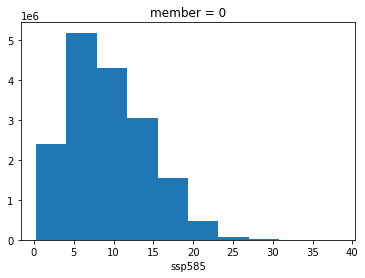

In [34]:
ncdf1.ssp585.isel(member=0).plot()

(array([4.100000e+01, 1.440000e+03, 3.836700e+04, 5.369460e+05,
        3.401833e+06, 8.924819e+06, 3.535952e+06, 5.714080e+05,
        4.194700e+04, 1.167000e+03]),
 array([-33.38538037, -27.33271705, -21.28005372, -15.2273904 ,
         -9.17472707,  -3.12206375,   2.93059958,   8.9832629 ,
         15.03592623,  21.08858955,  27.14125288]),
 <BarContainer object of 10 artists>)

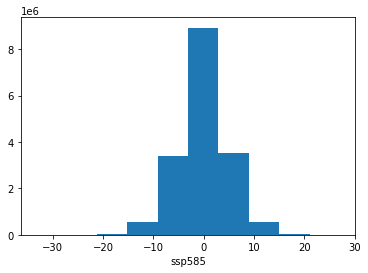

In [30]:
diff = ncdf1.ssp585.isel(member=1) - ncdf1.ssp585.isel(member=0)
diff.plot()

In [82]:
with Usfc_EU_win as ds:
    datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")
    merged = xr.merge([datain,ds])
    print(merged)

<xarray.DataArray 'ssp585' (day: 5459, lat: 16, lon: 21, member: 3)>
[5502672 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 32.08 34.87 37.65 40.44 ... 65.55 68.34 71.13 73.92
  * lon      (lon) float64 -28.12 -25.31 -22.5 -19.69 ... 19.69 22.5 25.31 28.12
  * member   (member) int64 0 1 2
  * day      (day) int64 1 2 3 4 5 6 7 ... 10761 10762 10763 10764 10765 10766


In [280]:
datain = xr.open_dataset(pathout+modname+'_'+basenamemet+".nc")
datain.lon

<xarray.DataArray 'lon' (lon: 144)>
array([-180. , -177.5, -175. , -172.5, -170. , -167.5, -165. , -162.5, -160. ,
       -157.5, -155. , -152.5, -150. , -147.5, -145. , -142.5, -140. , -137.5,
       -135. , -132.5, -130. , -127.5, -125. , -122.5, -120. , -117.5, -115. ,
       -112.5, -110. , -107.5, -105. , -102.5, -100. ,  -97.5,  -95. ,  -92.5,
        -90. ,  -87.5,  -85. ,  -82.5,  -80. ,  -77.5,  -75. ,  -72.5,  -70. ,
        -67.5,  -65. ,  -62.5,  -60. ,  -57.5,  -55. ,  -52.5,  -50. ,  -47.5,
        -45. ,  -42.5,  -40. ,  -37.5,  -35. ,  -32.5,  -30. ,  -27.5,  -25. ,
        -22.5,  -20. ,  -17.5,  -15. ,  -12.5,  -10. ,   -7.5,   -5. ,   -2.5,
          0. ,    2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,   20. ,
         22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,   40. ,   42.5,
         45. ,   47.5,   50. ,   52.5,   55. ,   57.5,   60. ,   62.5,   65. ,
         67.5,   70. ,   72.5,   75. ,   77.5,   80. ,   82.5,   85. ,   87.5,
         90. ,   92.5,   95. ,   97.5,  100. ,  102.5,  105. ,  107.5,  110. ,
        112.5,  115. ,  117.5,  120. ,  122.5,  125. ,  127.5,  130. ,  132.5,
        135. ,  137.5,  140. ,  142.5,  145. ,  147.5,  150. ,  152.5,  155. ,
        157.5,  160. ,  162.5,  165. ,  167.5,  170. ,  172.5,  175. ,  177.5])
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5

uzmemf_mri = uzmemf
utemp_mri = utemp
uinterp_mri = uinterp